In [1]:
from z3 import *
import z3
import pandas as pd
import time
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from itertools import islice
from functools import reduce
from typing import List

In [2]:
def parse_queries_from_klee_smt2_dump(path: str):
    queries = []
    with open(path) as f:
        current = ""
        for line in f:
            if line == "(check-sat)":
                continue
            if line.strip() == "(reset)":
                queries.append(z3.parse_smt2_string(current))
                current = ""
            current += line
    return queries

In [3]:
# queries = parse_queries_from_klee_smt2_dump("sort-cache-notimelimit.smt2")
queries = parse_queries_from_klee_smt2_dump("who-cache.smt2")
print(f"{len(queries)} queries were loaded.")

3090 queries were loaded.


In [4]:
def calc_distance_keeping_constraint_order(first: list, second: list, pop_cost, push_cost):
    """
    Calculates a distance between two queries while not trying to change the order
    of constraints inside them.
    The returned distance mimics the cost of pushing and popping when the second query
    is solved right after the first query.
    """
    i = 0
    while i < len(first) and i < len(second) and first[i].eq(second[i]):
        i += 1

    return (i, pop_cost(len(first) - i) + push_cost(len(second) - i))
    # If you believe that there's no cost in popping, you can use the following
    # formula. But personally, I see each pop as a negative thing and losing a
    # progress.
    # return (i, len(second) - i)

def calc_distances_for(query_index: int, queries, calc_distance, pop_cost, push_cost):
    query = queries[query_index]
    distances = [0] * len(queries)
    for j in range(len(queries)):
        distances[j] = calc_distance(query, queries[j], pop_cost, push_cost)
    return distances

pop_cost = lambda x: x
push_cost = lambda x: x

def calc_distances_for_map(query_index: int):
    return calc_distances_for(query_index, queries, calc_distance_keeping_constraint_order, pop_cost, push_cost)

In [5]:
with ProcessPoolExecutor() as executor:
    distances = list(tqdm(executor.map(calc_distances_for_map, range(len(queries))), total=len(queries)))

common_prefix_lens = [[col[0] for col in row] for row in distances]
distances = [[col[1] for col in row] for row in distances]

100%|██████████| 3090/3090 [00:14<00:00, 214.32it/s]


In [6]:
common_prefix_lens = pd.Series([pd.Series(cpl) for cpl in common_prefix_lens])

In [7]:
def check_by_resetting(queries, ordering, solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}
    
    total_time = 0.0
    
    ordering_iter = tqdm(ordering) if enable_tqdm else ordering
    for index in ordering_iter:
        query = queries[index]
        start_time = time.perf_counter()
        result = solver.check(query)
        end_time = time.perf_counter()
        total_time += end_time - start_time
        results[index] = result
    
    return results, total_time
    

def check_mixed_incrementally(queries, ordering, cpl, solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}
    
    total_time = 0.0
    
    # assert len(set([str(q[:cpl]) for q in [queries[qi] for qi in ordering]])) == 1
    solver.add(queries[ordering[0]][:cpl])
    ordering_iter = tqdm(ordering) if enable_tqdm else ordering
    for index in ordering_iter:
        query = queries[index]
        start_time = time.perf_counter()
        solver.push()
        solver.add(query[cpl:])
        result = solver.check()
        solver.pop()
        end_time = time.perf_counter()
        total_time += end_time - start_time
        results[index] = result
    
    return results, total_time

def check_dummy_incrementally(queries, ordering: List[int], solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}

    last_query = []

    total_time = 0.0
    total_pops = 0
    total_pushes = 0

    ordering_iter = tqdm(ordering) if enable_tqdm else ordering
    for index in ordering_iter:
        if index in results:
            print("Warning: Skipping repeated query. Query index =", index)
            continue
        query = queries[index]
        
        i = 0
        while i < len(last_query) and i < len(query) and last_query[i].eq(query[i]):
            i += 1

        start_time = time.perf_counter()
        
        solver.pop(len(last_query) - i)
        total_pops += len(last_query) - i

        for i in range(i, len(query)):
            solver.push()
            total_pushes += 1
            solver.add(query[i])
        
        result = solver.check()
        end_time = time.perf_counter()
        total_time += end_time - start_time
        results[index] = result

        last_query = query
    
    return (results, total_time, (total_pushes, total_pops, sum(len(q) for q in queries)))

def check_incrementally(queries, ordering: List[int], common_prefix_lens, enable_direct_subset_answer=False, solver=None, enable_tqdm=False):
    solver = solver if solver is not None else Solver()
    results = {}

    queries = queries + [queries[ordering[-1]]]
    ordering = ordering + [ordering[-1]]
    
    last_index = len(queries) - 1
    current_stack_count = 0

    total_time = 0.0
    total_pops = 0
    total_pushes = 0

    ordering_iter = zip(ordering[:len(ordering) - 1], ordering[1:])
    if enable_tqdm:
        ordering_iter = tqdm(ordering_iter, total=len(ordering) - 1)
    for index, next_index in ordering_iter:
        if index in results:
            print("Warning: Skipping repeated query. Query index =", index)
            continue
        # last_query = queries[last_index]
        query = queries[index]
        
        next_prefix_len = common_prefix_lens[index][next_index]

        start_time = time.perf_counter()
        if enable_direct_subset_answer and current_stack_count == len(query) and results[last_index] == sat:
            results[index] = sat
        else:
            if current_stack_count < next_prefix_len:
                for i in range(current_stack_count, next_prefix_len):
                    solver.push()
                    solver.add(query[i])
                total_pushes += next_prefix_len - current_stack_count
                current_stack_count = next_prefix_len

            solver.push()
            total_pushes += 1
            solver.add(query[current_stack_count:])
            
            result = solver.check()

            solver.pop()
            total_pops +=1
                        
            results[index] = result
        
        if current_stack_count > next_prefix_len:
            solver.pop(current_stack_count - next_prefix_len)
            total_pops += current_stack_count - next_prefix_len
            current_stack_count = next_prefix_len

        end_time = time.perf_counter()
        total_time += end_time - start_time
        last_index = index
    
    return (results, total_time, (total_pushes, total_pops, sum(len(q) for q in queries)))

def benchmark(f, repeat=30):
    times = list()
    for i in tqdm(range(repeat)):
        spent_time = f()[1]
        times.append(spent_time)
    return times

266    355
260    338
2      321
267    234
265    233
259    204
264    138
273    131
262    113
263    112
272    104
3       89
4       81
279     76
268     66
269     59
280     55
274     51
1       51
271     51
270     43
278     43
261     34
275     29
276     28
281     16
277     15
282     14
5        3
283      3
dtype: int64

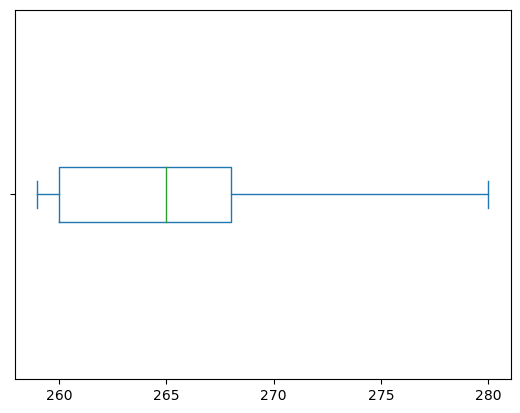

In [10]:
query_lens = pd.Series(len(q) for q in queries)
query_lens.plot.box(vert=False, showfliers=False)
# query_lens[query_lens < 270][query_lens > 230].hist()
query_lens.value_counts()

In [31]:
target_queries = pd.DataFrame(query_lens[query_lens > 220], columns=["Length"])
target_queries["CPL"] = common_prefix_lens[target_queries.index]
target_queries["CPLR"] = target_queries["CPL"] / target_queries["Length"]
target_queries["CPL_0"] = target_queries["CPLR"].map(lambda rs: (rs > 0.01).sum())
target_queries["CPL_0.01"] = target_queries["CPLR"].map(lambda rs: (0.1 >= rs[rs > 0.01]).sum())
target_queries["CPL_0.1"] = target_queries["CPLR"].map(lambda rs: (0.2 >= rs[rs > 0.1]).sum())
target_queries["CPL_0.2"] = target_queries["CPLR"].map(lambda rs: (0.5 >= rs[rs > 0.2]).sum())
target_queries["CPL_0.5"] = target_queries["CPLR"].map(lambda rs: (0.8 >= rs[rs > 0.5]).sum())
target_queries["CPL_0.5_nl"] = target_queries["CPLR"].map(lambda rs: (rs > 0.5).sum())
target_queries["CPL_10"] = target_queries["CPL"].map(lambda ls: (ls > 10).sum())
target_queries["CPL_20"] = target_queries["CPL"].map(lambda ls: (ls > 20).sum())
target_queries["CPL_30"] = target_queries["CPL"].map(lambda ls: (ls > 30).sum())
target_queries

,Length,CPL,CPLR,CPL_0,CPL_0.01,CPL_0.1,CPL_0.2,CPL_0.5,CPL_0.5_nl,CPL_10,CPL_20,CPL_30
43,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0,4,4,4,4
44,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0,4,4,4,4
45,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0,4,4,4,4
46,259,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,4,0,0,0,0,4,4,4,4
48,260,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,12,8,0,0,0,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3071,267,0 0 1 0 2 0 3 0 4 ...,0 0.000000 1 0.000000 2 0.00...,28,25,0,0,0,3,3,3,3
3072,269,0 0 1 0 2 0 3 0 4 ...,0 0.000000 1 0.000000 2 0.00...,28,27,0,0,0,1,1,1,1
3083,268,0 0 1 0 2 0 3 0 4 ...,0 0.0 1 0.0 2 0.0 3 0....,7,6,0,0,0,1,1,1,1
3087,268,0 0 1 0 2 0 3 ...,0 0.0 1 0.0 2 0.0 3 0....,8,7,0,0,0,1,1,1,1


In [38]:
target_queries["CPL_10"].value_counts()

4     720
3     717
1     631
2     210
11     55
6      54
15     45
5      30
7      28
18     18
8      16
12     12
9       9
Name: CPL_10, dtype: int64

In [44]:
target_queries = pd.DataFrame(query_lens[query_lens > 220], columns=["Length"])
target_queries["CPL"] = common_prefix_lens[target_queries.index]
target_queries["CPL_10"] = target_queries["CPL"].map(lambda ls: (ls > 10).sum())
target_queries["CPL_30"] = target_queries["CPL"].map(lambda ls: (ls > 30).sum())
target_queries = target_queries[target_queries["CPL_10"] > 10]

print(target_queries.groupby("CPL_10").std(numeric_only=True))

target_queries = target_queries[target_queries["CPL_10"] == 11]
# assert len(set([str(q[:53]) for q in [queries[qi] for qi in target_queries.index]])) == 1
# target_subset = target_queries.iloc[0]["CPL"]
# target_subset = target_subset[target_subset > 30]
# target_queries.loc[target_subset.index]

target_queries


          Length    CPL_30
CPL_10                    
11      3.184559  0.860663
12      3.446562  0.000000
15      2.489980  0.000000
18      0.383482  0.000000


,Length,CPL,CPL_10,CPL_30
367,272,0 0 1 0 2 0 3 0 4 ...,11,4
368,272,0 0 1 0 2 0 3 0 4 ...,11,4
369,272,0 0 1 0 2 0 3 0 4 ...,11,4
370,272,0 0 1 0 2 0 3 0 4 ...,11,4
542,273,0 0 1 0 2 0 3 0 4 ...,11,3
543,273,0 0 1 0 2 0 3 0 4 ...,11,3
544,273,0 0 1 0 2 0 3 0 4 ...,11,3
547,273,0 0 1 0 2 0 3 0 4 ...,11,3
548,273,0 0 1 0 2 0 3 0 4 ...,11,3
549,273,0 0 1 0 2 0 3 0 4 ...,11,3


In [54]:
cpl = common_prefix_lens[367]
cpl[cpl >= 11]

367    272
368    271
369    271
370    271
663     11
664     11
665     11
666     11
897     11
898     11
899     11
dtype: int64

In [44]:
result_res = check_by_resetting(queries, list(target_queries.index), enable_tqdm=True)[0]
result_mincr = check_mixed_incrementally(queries, list(target_queries.index), cpl, enable_tqdm=True)[0]
result_dincr = check_dummy_incrementally(queries, list(target_queries.index), enable_tqdm=True)[0]
result_incr = check_incrementally(queries, list(target_queries.index), common_prefix_lens, enable_tqdm=True)[0]

assert result_res == result_mincr
assert result_mincr == result_dincr
assert result_dincr == result_incr

100%|██████████| 53/53 [00:00<00:00, 363.75it/s]


In [46]:
time_res = benchmark(lambda: check_by_resetting(queries, list(target_queries.index)))
time_mincr = benchmark(lambda: check_mixed_incrementally(queries, list(target_queries.index), cpl))
time_dincr = benchmark(lambda: check_dummy_incrementally(queries, list(target_queries.index)))
time_incr = benchmark(lambda: check_incrementally(queries, list(target_queries.index), common_prefix_lens))

time_res = pd.Series(time_res)
time_mincr = pd.Series(time_mincr)
time_dincr = pd.Series(time_dincr)
time_incr = pd.Series(time_incr)

print("Time resetting:", time_res.describe())
print("Time mixed incrementally:", time_mincr.describe())
print("Time dummy incrementally:", time_dincr.describe())
print("Time incrementally:", time_incr.describe())

100%|██████████| 30/30 [00:04<00:00,  7.01it/s]

Time resetting: count    30.000000
mean      0.445354
std       0.011528
min       0.423058
25%       0.434448
50%       0.447259
75%       0.453720
max       0.471811
dtype: float64
Time mixed incrementally: count    30.000000
mean      0.170725
std       0.009252
min       0.151977
25%       0.165574
50%       0.169787
75%       0.176714
max       0.189960
dtype: float64
Time dummy incrementally: count    30.000000
mean      0.139641
std       0.007820
min       0.125355
25%       0.133156
50%       0.137868
75%       0.144146
max       0.157374
dtype: float64
Time incrementally: count    30.000000
mean      0.134756
std       0.010388
min       0.115717
25%       0.130255
50%       0.133787
75%       0.143081
max       0.155378
dtype: float64


In [57]:
def simulate_resetting(query, repeat=30, solver=None):
    solver = solver if solver is not None else Solver()
    times = list()
    for i in range(repeat):
        start_time = time.perf_counter()
        solver.check(query)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    return times

def simulate_mixed_incremental(query, repeat=30, solver=None):
    solver = solver if solver is not None else Solver()
    times = list()
    cpl = len(query) // 2
    solver.add(query[:cpl])
    for i in range(repeat):
        start_time = time.perf_counter()
        solver.push()
        solver.add(query[cpl:])
        solver.check()
        solver.pop()
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    
    solver.reset()
    return times

In [54]:
longest_query = max(queries, key=lambda q: len(q))
longest_len = len(longest_query)
longest_queries = [(i, q) for i, q in enumerate(queries) if len(q) == longest_len - 1]

# longest_query = queries[4293]
solver = Solver()
for i, q in longest_queries:
    print(i, solver.check(q))
# solver.set(timeout=30000)
# result, time_d = check_by_resetting([longest_query], [0], solver=solver)
# result, time_d

4266 unsat
4267 unsat
4270 sat


In [58]:
print(pd.Series(simulate_resetting(queries[4270])).describe())
print(pd.Series(simulate_mixed_incremental(queries[4270])).describe())

count    30.000000
mean      0.074052
std       0.045576
min       0.058748
25%       0.059909
50%       0.061173
75%       0.061783
max       0.266686
dtype: float64
count    30.000000
mean      0.032398
std       0.023303
min       0.027135
25%       0.027529
50%       0.027876
75%       0.028287
max       0.155605
dtype: float64
